Installing packages and importing Libraries and Model:

In [3]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install cobra

Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline



In [8]:
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
model = read_sbml_model('modified_model.xml')

import cobra
#from cobra.io import load_model
#model = load_model('modified_model.xml')

model.objective = model.reactions.EFE_m
model.optimize()


,fluxes,reduced_costs
EX_cm_e,0.000000,0.000000
EX_cmp_e,0.000000,-3.602649
EX_co2_e,34.438852,0.000000
EX_cobalt2_e,0.000000,0.000000
DM_4crsol_c,0.000000,0.000000
...,...,...
DM_eth_c,12.780574,0.000000
EX_eth_e,0.000000,0.000000
DM_hlarg_c,0.000000,0.000000
DM_guan_c,0.000000,0.000000


Building the dynamic system:

In [9]:
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose, ethylene = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""
    
    print("Current time:", t)
    print("Current state:", y)

    biomass, glucose, ethylene = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['BIOMASS_Ec_iJO1366_core_53p95M', 'EX_glc__D_e', 'EFE_m'], ['max', 'max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        print("Feasibility:", feasibility)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

Running the dynamic Simulation:

In [10]:
ts = np.linspace(0, 4, 100)  # Desired integration resolution and interval (startpoint (min), endpoint (min), calculations inbetween?)
y0 = [0.1, 10, 0] # Define starting concentrations (i.e. 0.1 g/L biomass, 10 g/L Glucose, 0.1 g/L ethanol)

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6, #relative tolerane, increase this value if infeasable event
        atol=1e-8, #absolute tolerance, increase when infeasable event
        method='BDF'
    )

0it [00:00, ?it/s]

Current time: 0.0
Current state: [ 0.1 10.   0. ]


t = 0.000: : 1it [00:03,  3.35s/it]

Current time: 0.022695260907302606
Current state: [1.01476462e-01 9.98486983e+00 8.08315666e-17]


t = 0.023: : 2it [00:06,  3.45s/it]

Current time: 0.0
Current state: [ 0.1 10.   0. ]


t = 0.000: : 3it [00:10,  3.54s/it]

Current time: 0.0
Current state: [ 0.1 10.   0. ]


t = 0.000: : 4it [00:14,  3.54s/it]

Current time: 0.0
Current state: [0.1        9.99999985 0.        ]


t = 0.000: : 5it [00:17,  3.56s/it]

Current time: 0.0
Current state: [ 1.00000000e-01  1.00000000e+01 -1.49011612e-16]


t = 0.000: : 6it [00:21,  3.54s/it]

Current time: 0.0
Current state: [ 1.00000000e-01  1.00000000e+01 -1.49011612e-15]


t = 0.000: : 7it [00:24,  3.47s/it]

Feasibility: 0.0
Current time: 0.00017059447244116224
Current state: [1.00011098e-01 9.99988627e+00 6.07590215e-19]


t = 0.000: : 8it [00:31,  4.52s/it]

Current time: 0.00017059447244116224
Current state: [1.00011099e-01 9.99988626e+00 1.29786103e-18]


t = 0.000: : 9it [00:34,  4.27s/it]

Feasibility: 0.0
Current time: 0.0003411889448823245
Current state: [1.00022198e-01 9.99977252e+00 3.54257770e-18]


t = 0.000: : 10it [00:41,  5.03s/it]

Current time: 0.0003411889448823245
Current state: [1.00022200e-01 9.99977251e+00 1.54228614e-18]


t = 0.000: : 11it [00:45,  4.56s/it]

Feasibility: 0.0
Current time: 0.0020471336692939467
Current state: [1.00133203e-01 9.99863499e+00 8.93563284e-18]


t = 0.002: : 12it [00:52,  5.28s/it]

Current time: 0.0020471336692939467
Current state: [ 1.00133305e-01  9.99863394e+00 -6.95318081e-17]


t = 0.002: : 13it [00:56,  4.87s/it]

Feasibility: 0.0
Current time: 0.003753078393705569
Current state: [ 1.00244411e-01  9.99749537e+00 -2.47691094e-17]


t = 0.004: : 14it [01:02,  5.36s/it]

Current time: 0.003753078393705569
Current state: [ 1.00244527e-01  9.99749418e+00 -1.24160833e-16]


t = 0.004: : 15it [01:06,  4.94s/it]

Feasibility: 0.0
Current time: 0.009704925095823234
Current state: [ 1.00633481e-01  9.99350833e+00 -7.45475076e-17]


t = 0.010: : 16it [01:13,  5.59s/it]

Current time: 0.009704925095823234
Current state: [ 1.00633425e-01  9.99350890e+00 -9.47088765e-18]


t = 0.010: : 17it [01:17,  4.97s/it]

Feasibility: 0.0
Current time: 0.0156567717979409
Current state: [ 1.01023685e-01  9.98950966e+00 -1.04521321e-16]


t = 0.016: : 18it [01:24,  5.60s/it]

Current time: 0.0156567717979409
Current state: [ 1.01023737e-01  9.98950912e+00 -2.24363890e-16]


t = 0.016: : 19it [01:27,  4.96s/it]

Feasibility: 0.0
Current time: 0.021608618500058567
Current state: [ 1.01415463e-01  9.98549485e+00 -4.45425060e-17]


t = 0.022: : 20it [01:34,  5.58s/it]

Current time: 0.021608618500058567
Current state: [ 1.01415497e-01  9.98549449e+00 -2.08083617e-16]


t = 0.022: : 21it [01:38,  4.92s/it]

Feasibility: 0.0
Current time: 0.03727548549989246
Current state: [1.02453894e-01 9.97485329e+00 1.87928314e-16]


t = 0.037: : 22it [01:44,  5.36s/it]

Current time: 0.03727548549989246
Current state: [1.02453689e-01 9.97485539e+00 8.65407610e-16]


t = 0.037: : 23it [01:48,  4.98s/it]

Feasibility: 0.0
Current time: 0.05294235249972635
Current state: [ 1.03502375e-01  9.96410867e+00 -2.38676170e-16]


t = 0.053: : 24it [01:54,  5.40s/it]

Current time: 0.05294235249972635
Current state: [1.03502150e-01 9.96411097e+00 9.14698372e-16]


t = 0.053: : 25it [01:58,  4.83s/it]

Feasibility: 0.0
Current time: 0.06860921949956024
Current state: [ 1.04561078e-01  9.95325921e+00 -3.72570571e-16]


t = 0.069: : 26it [02:05,  5.54s/it]

Current time: 0.06860921949956024
Current state: [1.04560968e-01 9.95326034e+00 2.67011182e-16]


t = 0.069: : 27it [02:09,  4.92s/it]

Feasibility: 0.0
Current time: 0.08427608649939414
Current state: [ 1.05630233e-01  9.94230256e+00 -3.44093763e-17]


t = 0.084: : 28it [02:16,  5.78s/it]

Current time: 0.08427608649939414
Current state: [ 1.05630218e-01  9.94230272e+00 -1.27795113e-16]


t = 0.084: : 29it [02:20,  5.03s/it]

Feasibility: 0.0
Current time: 0.12683084607903
Current state: [ 1.08587770e-01  9.91199345e+00 -2.48513195e-16]


t = 0.127: : 30it [02:26,  5.42s/it]

Current time: 0.12683084607903
Current state: [ 1.08587946e-01  9.91199164e+00 -2.26007816e-15]


t = 0.127: : 31it [02:30,  5.14s/it]

Feasibility: 0.0
Current time: 0.16938560565866587
Current state: [ 1.11625000e-01  9.88086699e+00 -1.00071797e-15]


t = 0.169: : 32it [02:37,  5.52s/it]

Current time: 0.16938560565866587
Current state: [ 1.11625198e-01  9.88086495e+00 -2.98464667e-15]


t = 0.169: : 33it [02:40,  4.84s/it]

Feasibility: 0.0
Current time: 0.21194036523830173
Current state: [ 1.14743818e-01  9.84890369e+00 -1.33339133e-15]


t = 0.212: : 34it [02:48,  5.74s/it]

Current time: 0.21194036523830173
Current state: [ 1.14743925e-01  9.84890259e+00 -2.32571904e-15]


t = 0.212: : 35it [02:51,  5.00s/it]

Feasibility: 0.0
Current time: 0.25449512481793757
Current state: [ 1.17946078e-01  9.81608451e+00 -1.95685268e-15]


t = 0.254: : 36it [02:58,  5.51s/it]

Current time: 0.25449512481793757
Current state: [ 1.17946117e-01  9.81608410e+00 -2.13237040e-15]


t = 0.254: : 37it [03:01,  4.85s/it]

Feasibility: 0.0
Current time: 0.3489535563505282
Current state: [ 1.25362255e-01  9.74007504e+00 -2.48568352e-15]


t = 0.349: : 38it [03:09,  5.74s/it]

Current time: 0.3489535563505282
Current state: [ 1.25362467e-01  9.74007283e+00 -8.51747279e-15]


t = 0.349: : 39it [03:13,  5.07s/it]

Feasibility: 0.0
Current time: 0.44341198788311886
Current state: [ 1.33222063e-01  9.65951429e+00 -3.02062084e-16]


t = 0.443: : 40it [03:19,  5.50s/it]

Current time: 0.44341198788311886
Current state: [ 1.33222622e-01  9.65950847e+00 -1.66930507e-14]


t = 0.443: : 41it [03:24,  5.25s/it]

Feasibility: 0.0
Current time: 0.5378704194157096
Current state: [ 1.41549128e-01  9.57415920e+00 -2.10127557e-15]


t = 0.538: : 42it [03:30,  5.63s/it]

Current time: 0.5378704194157096
Current state: [ 1.41549899e-01  9.57415117e+00 -2.35826087e-14]


t = 0.538: : 43it [03:34,  4.92s/it]

Feasibility: 0.0
Current time: 0.6323288509483003
Current state: [ 1.50367614e-01  9.48376106e+00 -4.52057518e-15]


t = 0.632: : 44it [03:40,  5.43s/it]

Current time: 0.6323288509483003
Current state: [ 1.50368408e-01  9.48375278e+00 -2.41852593e-14]


t = 0.632: : 45it [03:45,  5.26s/it]

Feasibility: 0.0
Current time: 0.8273692401029903
Current state: [ 1.70239118e-01  9.28003608e+00 -8.50712330e-15]


t = 0.827: : 46it [03:52,  5.64s/it]

Current time: 0.8273692401029903
Current state: [1.70238386e-01 9.28004343e+00 2.71637786e-14]


t = 0.827: : 47it [03:55,  4.93s/it]

Feasibility: 0.0
Current time: 1.0224096292576803
Current state: [ 1.92537581e-01  9.05139152e+00 -2.33444203e-15]


t = 1.022: : 48it [04:01,  5.43s/it]

Current time: 1.0224096292576803
Current state: [1.92535444e-01 9.05141283e+00 9.21180068e-14]


t = 1.022: : 49it [04:05,  4.75s/it]

Feasibility: 0.0
Current time: 1.2174500184123702
Current state: [ 2.17497510e-01  8.79540582e+00 -1.02891872e-14]


t = 1.217: : 50it [04:13,  5.84s/it]

Current time: 1.2174500184123702
Current state: [2.17493326e-01 8.79544767e+00 1.90343758e-13]


t = 1.217: : 51it [04:16,  5.10s/it]

Current time: 1.1738024868880519
Current state: [ 2.11667213e-01  8.85520518e+00 -1.08756031e-14]


t = 1.174: : 52it [04:20,  4.52s/it]

Current time: 1.1738024868880519
Current state: [2.11665136e-01 8.85522595e+00 8.77141342e-14]


t = 1.174: : 53it [04:23,  4.17s/it]

Current time: 1.1738024868880519
Current state: [ 2.11665173e-01  8.85522558e+00 -1.23683508e-14]


t = 1.174: : 54it [04:26,  3.89s/it]

Feasibility: 0.0
Current time: 1.3251953445184235
Current state: [ 2.32510278e-01  8.64140901e+00 -1.14553114e-14]


t = 1.325: : 55it [04:34,  5.23s/it]

Current time: 1.3251953445184235
Current state: [2.32508346e-01 8.64142840e+00 7.88612392e-14]


t = 1.325: : 56it [04:38,  4.66s/it]

Current time: 1.3251953445184235
Current state: [ 2.32508382e-01  8.64142803e+00 -1.34035058e-14]


t = 1.325: : 57it [04:41,  4.24s/it]

Feasibility: 0.0
Current time: 1.476588202148795
Current state: [ 2.55175430e-01  8.40887639e+00 -2.30679785e-14]


t = 1.477: : 58it [04:48,  4.98s/it]

Current time: 1.476588202148795
Current state: [2.55173164e-01 8.40889918e+00 9.10788905e-14]


t = 1.477: : 59it [04:51,  4.46s/it]

Current time: 1.476588202148795
Current state: [ 2.55173209e-01  8.40889872e+00 -1.94044179e-14]


t = 1.477: : 60it [04:54,  4.16s/it]

Feasibility: 0.0
Current time: 1.6279810597791666
Current state: [ 2.79765819e-01  8.15653384e+00 -2.83404065e-14]


t = 1.628: : 61it [05:03,  5.48s/it]

Current time: 1.6279810597791666
Current state: [2.79762678e-01 8.15656548e+00 1.27598289e-13]


t = 1.628: : 62it [05:06,  4.81s/it]

Current time: 1.6279810597791666
Current state: [ 2.79762744e-01  8.15656480e+00 -2.77435420e-14]


t = 1.628: : 63it [05:10,  4.36s/it]

Feasibility: 0.0
Current time: 1.7793739174095382
Current state: [ 3.06375037e-01  7.88340194e+00 -9.47668416e-15]


t = 1.779: : 64it [05:16,  5.10s/it]

Current time: 1.7793739174095382
Current state: [3.06370797e-01 7.88344468e+00 1.82783377e-13]


t = 1.779: : 65it [05:20,  4.54s/it]

Current time: 1.7793739174095382
Current state: [ 3.06370893e-01  7.88344370e+00 -2.81069372e-14]


t = 1.779: : 66it [05:23,  4.20s/it]

Feasibility: 0.0
Current time: 1.9120985517606146
Current state: [ 3.31422546e-01  7.62622594e+00 -3.46776520e-14]


t = 1.912: : 67it [05:32,  5.57s/it]

Current time: 1.9120985517606146
Current state: [ 3.31421998e-01  7.62623149e+00 -7.28502616e-15]


t = 1.912: : 68it [05:35,  4.90s/it]

Feasibility: 0.0
Current time: 2.044823186111691
Current state: [ 3.58128019e-01  7.35194343e+00 -1.93540547e-14]


t = 2.045: : 69it [05:42,  5.35s/it]

Current time: 2.044823186111691
Current state: [3.58126851e-01 7.35195524e+00 1.34264093e-14]


t = 2.045: : 70it [05:45,  4.78s/it]

Feasibility: 0.0
Current time: 2.1775478204627676
Current state: [ 3.86509682e-01  7.06034244e+00 -3.19455067e-14]


t = 2.178: : 71it [05:51,  5.25s/it]

Current time: 2.1775478204627676
Current state: [ 3.86509366e-01  7.06034567e+00 -1.78446124e-14]


t = 2.178: : 72it [05:55,  4.69s/it]

Feasibility: 0.0
Current time: 2.3102724548138442
Current state: [ 4.16572541e-01  6.75134332e+00 -1.96102221e-14]


t = 2.310: : 73it [06:04,  5.97s/it]

Current time: 2.3102724548138442
Current state: [ 4.16572060e-01  6.75134822e+00 -1.39548875e-14]


t = 2.310: : 74it [06:07,  5.13s/it]

Feasibility: 0.0
Current time: 2.442997089164921
Current state: [ 4.48291508e-01  6.42516901e+00 -4.08320567e-14]


t = 2.443: : 75it [06:13,  5.57s/it]

Current time: 2.442997089164921
Current state: [ 4.48290597e-01  6.42517826e+00 -3.15361698e-15]


t = 2.443: : 76it [06:17,  4.93s/it]

Feasibility: 0.0
Current time: 2.5757217235159975
Current state: [ 4.81608244e-01  6.08237721e+00 -4.33892869e-14]


t = 2.576: : 77it [06:23,  5.37s/it]

Current time: 2.5757217235159975
Current state: [ 4.81607269e-01  6.08238712e+00 -7.36914730e-15]


t = 2.576: : 78it [06:27,  4.82s/it]

Feasibility: 0.0
Current time: 2.711862836970605
Current state: [ 5.17339384e-01  5.71450531e+00 -2.70439106e-14]


t = 2.712: : 79it [06:33,  5.31s/it]

Current time: 2.711862836970605
Current state: [ 5.17338632e-01  5.71451299e+00 -1.53971525e-14]


t = 2.712: : 80it [06:39,  5.50s/it]

Feasibility: 0.0
Current time: 2.848003950425212
Current state: [ 5.54489586e-01  5.33172631e+00 -5.35355604e-14]


t = 2.848: : 81it [06:46,  5.83s/it]

Current time: 2.848003950425212
Current state: [ 5.54489182e-01  5.33173052e+00 -3.12879690e-14]


t = 2.848: : 82it [06:49,  5.06s/it]

Feasibility: 0.0
Current time: 2.9841450638798195
Current state: [ 5.92838579e-01  4.93622955e+00 -4.97223613e-14]


t = 2.984: : 83it [06:56,  5.49s/it]

Current time: 2.9841450638798195
Current state: [ 5.92838656e-01  4.93622893e+00 -5.20961599e-14]


t = 2.984: : 84it [06:59,  4.87s/it]

Feasibility: 0.0
Current time: 3.120286177334427
Current state: [ 6.32096753e-01  4.53090545e+00 -3.54723622e-14]


t = 3.120: : 85it [07:05,  5.35s/it]

Current time: 3.120286177334427
Current state: [ 6.32097665e-01  4.53089643e+00 -7.62404844e-14]


t = 3.120: : 86it [07:09,  4.71s/it]

Current time: 3.120286177334427
Current state: [ 6.32097636e-01  4.53089672e+00 -5.00484366e-14]


t = 3.120: : 87it [07:12,  4.32s/it]

Feasibility: 0.0
Current time: 3.256427290789034
Current state: [ 6.71900074e-01  4.11939794e+00 -5.18669011e-14]


t = 3.256: : 88it [07:22,  5.85s/it]

Current time: 3.256427290789034
Current state: [ 6.71902348e-01  4.11937521e+00 -1.16687771e-13]


t = 3.256: : 89it [07:25,  5.05s/it]

Current time: 3.256427290789034
Current state: [ 6.71902265e-01  4.11937605e+00 -4.32284868e-14]


t = 3.256: : 90it [07:28,  4.58s/it]

Feasibility: 0.0
Current time: 3.3925684042436415
Current state: [ 7.11808853e-01  3.70611811e+00 -5.03717988e-14]


t = 3.393: : 91it [07:34,  5.10s/it]

Current time: 3.3925684042436415
Current state: [ 7.11813063e-01  3.70607588e+00 -1.81605242e-13]


t = 3.393: : 92it [07:38,  4.59s/it]

Current time: 3.3925684042436415
Current state: [ 7.11812884e-01  3.70607768e+00 -4.13351157e-14]


t = 3.393: : 93it [07:41,  4.15s/it]

Current time: 3.3539624657830487
Current state: [ 7.00511162e-01  3.82319110e+00 -4.81889147e-14]


t = 3.354: : 94it [07:44,  3.90s/it]

Current time: 3.3539624657830487
Current state: [ 7.00512721e-01  3.82317546e+00 -9.68632105e-14]


t = 3.354: : 95it [07:48,  3.71s/it]

Current time: 3.3539624657830487
Current state: [ 7.00512658e-01  3.82317610e+00 -4.47123770e-14]


t = 3.354: : 96it [07:51,  3.56s/it]

Feasibility: 0.0
Current time: 3.4514976407770632
Current state: [ 7.28993363e-01  3.52791336e+00 -5.79633083e-14]


t = 3.451: : 97it [08:00,  5.34s/it]

Current time: 3.4514976407770632
Current state: [ 7.28994221e-01  3.52790472e+00 -8.23416195e-14]


t = 3.451: : 98it [08:04,  4.71s/it]

Current time: 3.4514976407770632
Current state: [ 7.28994183e-01  3.52790510e+00 -5.24394247e-14]


t = 3.451: : 99it [08:07,  4.26s/it]

Feasibility: 0.0
Current time: 3.5490328157710778
Current state: [ 7.57145067e-01  3.23559298e+00 -4.58991679e-14]


t = 3.549: : 100it [08:14,  5.00s/it]

Current time: 3.5490328157710778
Current state: [ 7.57145970e-01  3.23558388e+00 -8.30352661e-14]


t = 3.549: : 101it [08:17,  4.48s/it]

Current time: 3.5490328157710778
Current state: [ 7.57145927e-01  3.23558431e+00 -5.32321332e-14]


t = 3.549: : 102it [08:20,  4.15s/it]

Feasibility: 0.0
Current time: 3.6465679907650923
Current state: [ 7.84752716e-01  2.94838095e+00 -6.09241815e-14]


t = 3.647: : 103it [08:27,  4.87s/it]

Current time: 3.6465679907650923
Current state: [ 7.84754161e-01  2.94836640e+00 -1.05642475e-13]


t = 3.647: : 104it [08:30,  4.45s/it]

Current time: 3.6465679907650923
Current state: [ 7.84754087e-01  2.94836714e+00 -5.46936089e-14]


t = 3.647: : 105it [08:33,  4.09s/it]

Feasibility: 0.0
Current time: 3.744103165759107
Current state: [ 8.11595527e-01  2.66850360e+00 -6.88001885e-14]


t = 3.744: : 106it [08:44,  5.91s/it]

Current time: 3.744103165759107
Current state: [ 8.11597341e-01  2.66848532e+00 -1.20442718e-13]


t = 3.744: : 107it [08:47,  5.12s/it]

Current time: 3.744103165759107
Current state: [ 8.11597242e-01  2.66848632e+00 -6.06681966e-14]


t = 3.744: : 108it [08:50,  4.59s/it]

Feasibility: 0.0
Current time: 3.8416383407531214
Current state: [ 8.37451623e-01  2.39820109e+00 -6.25917485e-14]


t = 3.842: : 109it [08:57,  5.19s/it]

Current time: 3.8416383407531214
Current state: [ 8.37453380e-01  2.39818336e+00 -1.22061355e-13]


t = 3.842: : 110it [09:00,  4.64s/it]

Current time: 3.8416383407531214
Current state: [ 8.37453276e-01  2.39818441e+00 -6.20749683e-14]


t = 3.842: : 111it [09:03,  4.24s/it]

Feasibility: 0.0
Current time: 3.9179482744072396
Current state: [ 8.56854340e-01  2.19479898e+00 -6.25209543e-14]


t = 3.918: : 112it [09:10,  4.92s/it]

Current time: 3.9179482744072396
Current state: [ 8.56855038e-01  2.19479192e+00 -7.88349353e-14]


t = 3.918: : 113it [09:13,  4.48s/it]

Current time: 3.9179482744072396
Current state: [ 8.56855010e-01  2.19479220e+00 -6.70757025e-14]


t = 3.918: : 114it [09:17,  4.12s/it]

Feasibility: 0.0
Current time: 3.994258208061358
Current state: [ 8.75424686e-01  1.99956852e+00 -7.67571023e-14]


t = 3.994: : 115it [09:23,  4.85s/it]

Current time: 3.994258208061358
Current state: [ 8.75424772e-01  1.99956763e+00 -6.96366423e-14]


t = 3.994: : 116it [09:26,  4.36s/it]

Feasibility: 0.0
Current time: 4.0
Current state: [ 8.76785858e-01  1.98523414e+00 -6.80989066e-14]


t = 4.000: : 117it [09:37,  6.13s/it]

Current time: 4.0
Current state: [ 8.76785858e-01  1.98523414e+00 -6.82139727e-14]


t = 4.000: : 118it [09:40,  5.28s/it]

Feasibility: 0.0


t = 4.000: : 118it [09:43,  4.95s/it]


Looking at the data output and plotting it:

In [11]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  4.040e-02 ...  3.960e+00  4.000e+00]
        y: [[ 1.000e-01  1.027e-01 ...  8.671e-01  8.768e-01]
            [ 1.000e+01  9.973e+00 ...  2.087e+00  1.985e+00]
            [ 0.000e+00 -3.566e-17 ... -6.774e-14 -6.810e-14]]
      sol: None
 t_events: [array([], dtype=float64)]
 y_events: [array([], dtype=float64)]
     nfev: 113
     njev: 1
      nlu: 11

Text(0, 0.5, 'Glucose')

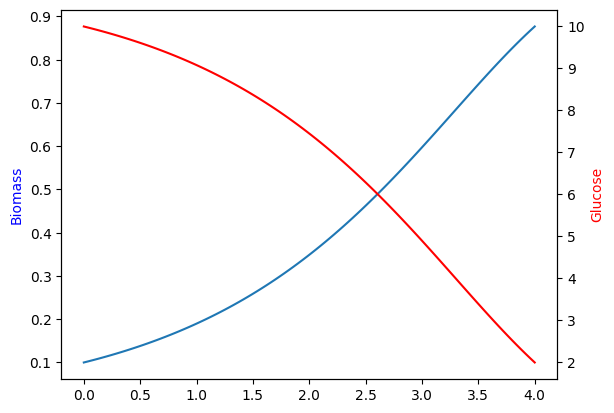

In [12]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')
#ax3 = plt.twinx(ax2)
#ax.plot(sol.t, sol.y.T[:, 2], label='Third Variable', color='g')


ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Glucose', color='r')
#ax.plot(sol.t, sol.y.T[:, 2], label='Third Variable', color='g')


Text(0, 0.5, 'Ethylene')

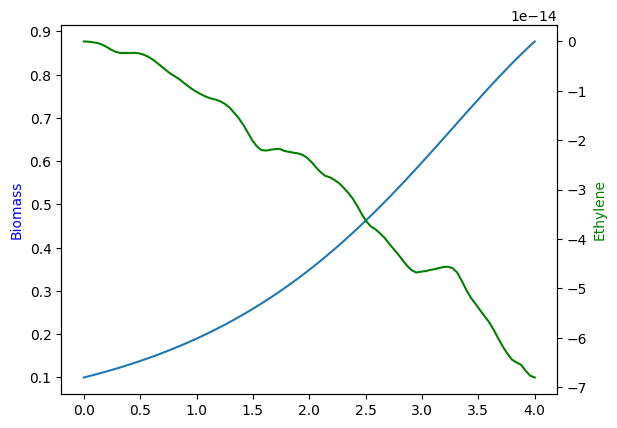

In [13]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 2], color='g')
#ax3 = plt.twinx(ax2)
#ax.plot(sol.t, sol.y.T[:, 2], label='Third Variable', color='g')


ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Ethylene', color='g')
#ax.plot(sol.t, sol.y.T[:, 2], label='Third Variable', color='g')
